In [1]:
from pygame import Rect

pygame 2.0.0.dev3 (SDL 2.0.9, python 3.7.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [464]:
import numpy as np


class NoFit(Exception):
    """The block does not fit inside a texture."""

    
class Tex:
    def __init__(self, size=512, threshold=0):
        self.bounds = Rect(0, 0, size, size)
        self.largest_dim = size
        self.contents = []
        self.threshold = threshold
        self.free = [self.bounds]

    def _solutions(self, r):
        """Iterate over possible locations for r in this texture."""
        if r.w > self.bounds.w and block.h > self.bounds.h:
            raise NoFit()
        rotations = [r]
        if r.h != r.w:
            rotations.append(Rect(0, 0, r.h, r.w))
            
        for r in rotations:
            for block in self.free:
                if block.w < r.w:
                    # We keep list sorted so we can break here
                    break
                elif block.h < r.h:
                    continue
                    
                yield r, block
        
    def _fitness(self, sol):
        """Return a value indicating the fitness of this localstion.
        
        Lower is better; the minimal value will be picked.
        """
        r, block = sol
        #rect = Rect(block.topleft, r.size)
        
        # Best area fit
        #return -(r.w * r.h) / (block.w * block.h)
        
        # Best short side fit
        if r.w < r.h:
            return block.w - r.w
        else:
            return block.h - r.h
        
        # Best any side fit
        # return min(block.w - r.w, block.h - r.h)
        
    def place(self, r):
        if not self.free:
            raise NoFit()
            
        try:
            r, block = min(
                self._solutions(r),
                key=self._fitness
            )
        except ValueError as e:
            if e.args[0] != 'min() arg is an empty sequence':
                raise
            raise NoFit() from None
            
        r.topleft = block.topleft    
        self.contents.append(r)
        
        new_free = [] # new rects already checked against threshold
        new_rects = []  # new rects to be checked
        for block in self.free:
            if not block.colliderect(r):
                new_free.append(block)
                continue
                
            new_rects.extend([
                Rect(block.left, block.top, block.w, r.top - block.top),  # Above r
                Rect(block.left, r.bottom, block.w, block.bottom - r.bottom),  # Below r
                Rect(block.left, block.top, r.left - block.left, block.h), # Left of r
                Rect(r.right, block.top, block.right - r.right, block.h),  # Right of r 
            ])
        
        new_free += [
            r for r in new_rects
            if min(r.size) > self.threshold
        ]
        
        # This is O(n¹) but I couldn't improve it by a sort-and sweep approach due to high
        # constant factors
        self.free = [
            r for r in new_free
            if not any(b.contains(r) for b in new_free if b is not r)
        ]
        self.free.sort(key=lambda block: block.w, reverse=True)

        return r
    
    def _combine_free(self, new_free):
        """Set self.free to new_free.
        
        To minimise the length of the list, eliminate any rectangle wholly
        contained within another.
        
        This use a sort-and-sweep approach, which should be O(N * M) where M ~ sqrt(N),
        so O(N ^ (3 / 2)). Unfortunately the constant factors are much too high.
        
        """
        self.free = []

        open = []
        edges = (
            [(r.left, True, r) for r in new_free] +
            [(r.right, False, r) for r in new_free]
        )
        edges.sort()
        for _, opening, r in edges:
            if opening:
                if not any(b.contains(r) for b in open):
                    open.append(r)
            else:
                # rects contain themselves so this discards r
                open = [b for b in open if not r.contains(b)]
                self.free.append(r)
        
    
class Packer:
    def __init__(self, fragment_threshold=0):
        self.texs = []
        self.threshold = fragment_threshold
        
    def new_tex(self):
        return Tex(threshold=self.threshold)
        
    def add(self, r):
        i = -1
        for i, t in enumerate(self.texs):
            try:
                result = t.place(r)
            except NoFit:
                continue
            else:
                return i, result
        new = self.new_tex()
        result = new.place(r)  
        self.texs.append(new)
        return i + 1, result
            

In [465]:
from matplotlib import pyplot as plt

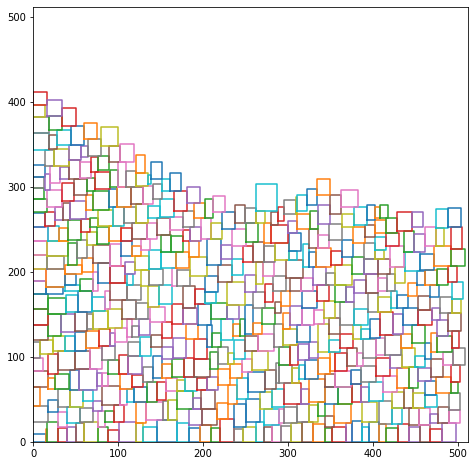

In [482]:
import random
from itertools import combinations

packer = Packer(fragment_threshold=16)

by_bin = {}

for i in range(500):
    w = abs(random.normalvariate(18, 4)) + 1
    h = abs(random.normalvariate(13, 4)) + 1
    bin, loc = packer.add(Rect(0, 0, w, h))
    by_bin.setdefault(bin, []).append(loc)
    
for rects in by_bin.values():
    for ra, rb in combinations(rects, 2):
        if ra.colliderect(rb):
            raise AssertionError(f"{ra} collides with {rb}")
            
for bin_id, rects in by_bin.items():
    bounds = packer.texs[bin_id].bounds
    for r in rects:
        if not bounds.contains(r):
            raise AssertionError(f"{r} is not within bounds {bounds}")

count = max(by_bin) + 1
fig, axes = plt.subplots(1, count, figsize=(20, 8))
if count < 2:
    axes = [axes]

for i, ax in enumerate(axes):
    bin = by_bin.get(i, ())
    ax.set_aspect(1)
    ax.set_xlim(0, 512)
    ax.set_ylim(0, 512)
    for r in bin:
        points = [r.topleft, r.topright, r.bottomright, r.bottomleft, r.topleft]
        xs, ys = zip(*points)
        ax.plot(xs, ys)
        

In [455]:
len(packer.texs[0].free)

48

In [485]:
import random
import timeit
import numpy as np

# Create the rects first
rects = []
for i in range(10000):
    w = max(random.normalvariate(18, 4), 1)
    h = max(random.normalvariate(13, 4), 1)
    rects.append(Rect(0, 0, w, h))

    
packer = Packer(fragment_threshold=16)
    
n = 0
cumtime = 0 

def packn():
    global n, cumtime
    n += 10
    start = timeit.default_timer()
    for r in rects[n - 10:n]:
        packer.add(r)
    end = timeit.default_timer()
    cumtime += (end - start) * 1000
    return n, len(packer.texs), cumtime
        

results = [packn() for _ in range(50)]
amounts, bins, times = zip(*results)

<BarContainer object of 50 artists>

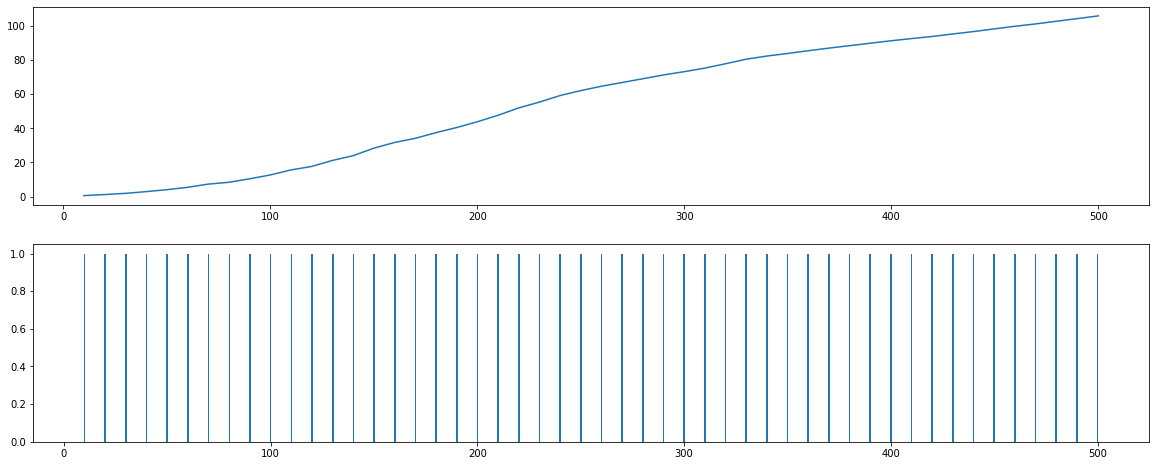

In [486]:
fig, (ts, bs) = plt.subplots(2, 1, figsize=(20, 8))
ts.plot(amounts, times)
bs.bar(amounts, bins)